# OMP Version 3
Discussed about the OMP rewriting, results are good. However, the OMP algorithm does not enforce DAGness. When the data is generated according to a VAR(1) with DAG, then we do not have to worry. 

However, another question then is, when we have a sparse DAG, when do we stop? We can continue adding edges until we violate the DAG assumption; then we stop. 

Alternatively, we can continue adding edges. When we see that we are about to add an edge that violates the DAGness, we discard this edge, and continue. We fix this constant to zero. We continue until we have a dense DAG (or similarly, until we have visited all nodes). This is a more principled approach, as we now also have an ordering of importance of the edges in our DAG. Then, when we want to prune our DAG, we can have a more principled approach than simply removing the smallest non-zero edge weight. Removing the smallest non-zero edge weight is not a principled approach, as a small edge weight does not imply a small importance. Using this OMP approach, we have a principled way of ordering the edges by importance. We can then prune by removing the edges from least important to most important.

In [1]:
import sys
import itertools

import numpy as np
import matplotlib.pyplot as plt

# Orthogonal matching
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV

sys.path.append("..")
import helper.helper as h

### Generate data
Generate $\texttt{T}$ samples of $\texttt{n}$ dimensions, where $A$ is generated as above with $\texttt{s}$ edges. The weighted adjacency matrix $\texttt{W_true}$ is generated by permuting the rows and columns of $A$ with a random permutation $\texttt{P_true}$.

A:
[[ 0.   0.   0.   0.   0. ]
 [-0.5 -0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  0. ]
 [ 0.   0.  -0.5  0.   0. ]]

P:
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]].

W:
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [-0.5  0.  -0.5  0.   0. ]
 [ 0.  -0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.5]]


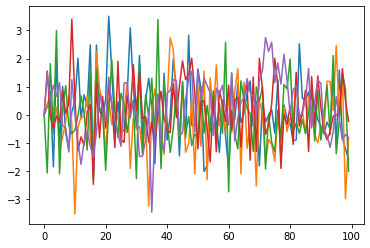

In [2]:
## Number of dimensions, number of edges, number of samples
T, n, s = 100, 5, 4

## Coefficient matrix
A_true = h.generate_A(n, s, tril = False, low = 0.5, high = 0.5)

## True permutation
P_true = np.random.permutation(np.identity(n))

W_true = P_true.T @ A_true @ P_true

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

# get X value and X prediction
X_val = X[1:]
X_pred = X[:-1]

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.\n\nW:\n{np.round(W_true, 2)}")

In [3]:
load = False
if load:
    # Get data name
    data_name = "X_s4_n3_T100_random_matrix_0"

    # Load data
    W_true, X, expl = h.load_data(data_name)

T, n = np.shape(X)

(495, 25)
(495, 1)
Edge (3, 1) added w/ coef -0.61. Increased score by 0.08.
Edge (3, 3) added w/ coef -0.51. Increased score by 0.06.
Edge (4, 2) added w/ coef -0.54. Increased score by 0.05.
Edge (5, 5) added w/ coef 0.46. Increased score by 0.04.
Edge (5, 2) added w/ coef -0.19. Increased score by 0.01.
Edge (4, 3) added w/ coef -0.17. Increased score by 0.0.
Edge (3, 4) added. violation! Removed.
Edge (5, 4) added w/ coef 0.15. Increased score by 0.0.
Edge (4, 4) added w/ coef -0.13. Increased score by 0.0.
Edge (2, 3) added w/ coef 0.11. Increased score by 0.0.
Edge (1, 5) added. violation! Removed.
Edge (5, 3) added w/ coef -0.08. Increased score by 0.0.
Edge (3, 2) added. violation! Removed.
Edge (1, 4) added. violation! Removed.
Edge (4, 5) added. violation! Removed.
Edge (5, 1) added w/ coef -0.05. Increased score by 0.0.
Edge (1, 1) added w/ coef 0.05. Increased score by 0.0.
Edge (2, 2) added w/ coef -0.04. Increased score by 0.0.
Edge (4, 1) added w/ coef 0.04. Increased sc

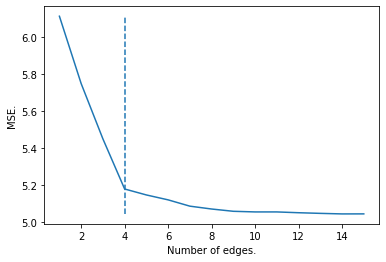

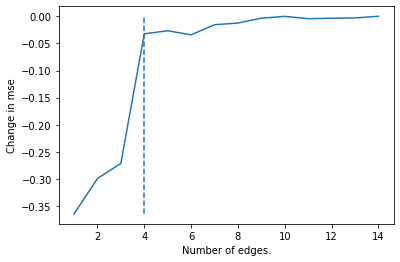

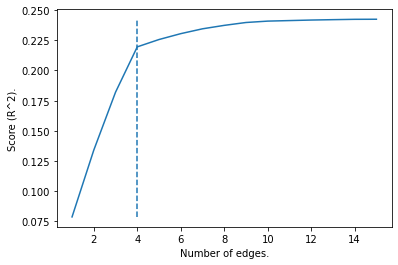

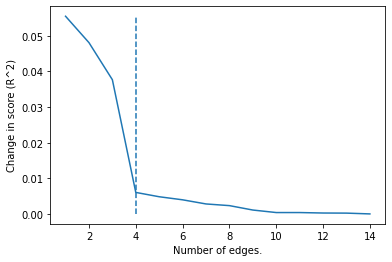

In [5]:
## Transform data
# Blockwise repeat of X
X_large = np.kron(np.eye(n, dtype=float), X[:-1])
print(np.shape(X_large))
X_DAG = X_large.copy()
# Stack all X on top of each other for y
y_large = X[1:].T.reshape((T - 1) * n, 1)
print(np.shape(y_large))
# scores to remember
edges, scores, mses = [], [], []

# how verbose we want the output to be
verbose = False

# old W
omp_coefs_old = np.zeros(n ** 2)

viols = 0

for i in range(1, n ** 2 + 1):
    
    # fit OMP for i coefficients
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs = i - viols)
    omp_fit = omp.fit(X_DAG, y_large)
    
    # get index of newly added edge
    omp_coefs_new = omp_fit.coef_.copy()
    
    # find the violating weight
    omp_coefs_diff = omp_coefs_new.copy()
    omp_coefs_diff[omp_coefs_old != 0] = 0
        
    edge_loc = np.array(np.where(omp_coefs_diff != 0))[0][0]
    
    # we check if we have violated the DAG constraint
    if not h.is_dag(omp_fit.coef_.reshape(n, n).T):
        ## option 1: We terminate the procedure
        print(f"Edge ({edge_loc % n + 1}, {edge_loc // n + 1}) added. violation! Removed.")
        # break
        
        ## option 2: We force this edge out, and continue
        # we force the edge out by setting the corresponding data to zero
        # this makes it by default the least desirable option
        # the data that corresponds to this coefficient is 
        to_remove = (edge_loc // n)  * n + edge_loc % n
        X_DAG[:, to_remove] = np.zeros((T - 1) * n)
    
        # increase number of violations, i - viols = number of coefs
        viols += 1
        
        # edge case: if violation at last iteration, we need to refit
        if i == n ** 2:
            # fit OMP for i coefficients
            omp = OrthogonalMatchingPursuit(n_nonzero_coefs = i - viols)
            omp_fit = omp.fit(X_DAG, y_large)
                
        continue
    else:
        edges.append((edge_loc % n + 1, edge_loc // n + 1))
        if i == 1:
            print(f"Edge ({edge_loc % n + 1}, {edge_loc // n + 1}) added w/ coef {round(omp_coefs_new[edge_loc], 2)}. Increased score by {round(omp.score(X_large, y_large), 2)}.")
        else:
            print(f"Edge ({edge_loc % n + 1}, {edge_loc // n + 1}) added w/ coef {round(omp_coefs_new[edge_loc], 2)}. Increased score by {round(omp.score(X_large, y_large) - scores[-1], 2)}.")
        
        
    # get results
    if verbose:
        print(np.round(omp_fit.coef_.reshape(n, n).T, 2))
        print(round(omp.score(X_large, y_large), 2))
        print(end="\n")
    
    # append results
    scores.append(omp.score(X_large, y_large))
    
    mses.append(h.MSE(omp_fit.coef_.reshape(n, n).T, X))
    
    # update coefficients
    omp_coefs_old = omp_coefs_new

W = np.round(omp_fit.coef_.reshape(n, n).T, 2)

plt.plot(range(1, len(mses) + 1), mses)
plt.vlines(s, min(mses), max(mses), linestyle = '--')
plt.xlabel("Number of edges.")
plt.ylabel("MSE.")
plt.show()

mses_diff = [a_i - b_i for a_i, b_i in zip(mses[1:], mses[:-1])]
plt.plot(range(1, len(mses_diff) + 1), mses_diff)
plt.vlines(s, min(mses_diff), max(mses_diff), linestyle = '--')
plt.xlabel("Number of edges.")
plt.ylabel("Change in mse")
plt.show()

plt.plot(range(1, len(scores) + 1), scores)
plt.vlines(s, min(scores), max(scores), linestyle = '--')
plt.xlabel("Number of edges.")
plt.ylabel("Score (R^2).")
plt.show()

scores_diff = [a_i - b_i for a_i, b_i in zip(scores[1:], scores[:-1])]
plt.plot(range(1, len(scores_diff) + 1), scores_diff)
plt.vlines(s, min(scores_diff), max(scores_diff), linestyle = '--')
plt.xlabel("Number of edges.")
plt.ylabel("Change in score (R^2)")
plt.show()

In [55]:
print("Edges with their accompanying scores:")
for i in range(len(scores)):
    if i == 0:
        print(f"Edge {edges[i]}. Score improvement: {round(scores[i], 2)}.")
    else:
        print(f"Edge {edges[i]}. Score improvement: {round(scores[i] - scores[i - 1], 2)}.")

Edges with their accompanying scores:
Edge (5, 3). Score improvement: 0.21.
Edge (3, 4). Score improvement: 0.07.
Edge (5, 5). Score improvement: 0.06.
Edge (10, 2). Score improvement: 0.04.
Edge (3, 3). Score improvement: 0.05.
Edge (10, 10). Score improvement: 0.03.
Edge (8, 2). Score improvement: 0.03.
Edge (4, 2). Score improvement: 0.02.
Edge (10, 8). Score improvement: 0.02.
Edge (1, 10). Score improvement: 0.02.
Edge (1, 3). Score improvement: 0.02.
Edge (9, 4). Score improvement: 0.01.
Edge (1, 2). Score improvement: 0.02.
Edge (9, 9). Score improvement: 0.01.
Edge (1, 1). Score improvement: 0.01.
Edge (10, 5). Score improvement: 0.01.
Edge (6, 5). Score improvement: 0.01.
Edge (6, 4). Score improvement: 0.01.
Edge (9, 2). Score improvement: 0.01.
Edge (7, 8). Score improvement: 0.01.
Edge (7, 2). Score improvement: 0.01.
Edge (8, 3). Score improvement: 0.01.
Edge (7, 5). Score improvement: 0.01.
Edge (7, 1). Score improvement: 0.01.
Edge (7, 3). Score improvement: 0.0.
Edge (7

In [23]:
print(W)
print(np.round(W_true, 2))
print(h.is_dag(W))

[[-0.39  0.    0.26]
 [ 0.25  0.07 -0.13]
 [ 0.    0.    0.15]]
[[-0.25  0.    0.25]
 [ 0.25  0.    0.  ]
 [ 0.   -0.25  0.  ]]
(True, [2, 0, 1])


### Iteratively removing the "least important" element
What we expect: For each element that we improve, the "structural performance measures" will improve until the number of non-zero coefficients is approximately the number of true edges in the graph. The "predictive performance measures" will decrease, but very very little, until we again have #nonzero = #edges. From thereon, we expect the predictive performance to decrease heavily.

[[-0.58  0.06  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.52 -0.53  0.08  0.    0.    0.    0.    0.    0.    0.  ]
 [-0.3   0.04  0.12  0.1   0.   -0.11 -0.43 -0.49 -0.29  0.01]
 [ 0.34 -0.19  0.39 -0.06  0.45 -0.13  0.14 -0.28 -0.55  0.08]
 [ 0.14 -0.54  0.03  0.    0.   -0.45  0.    0.    0.   -0.4 ]
 [ 0.63 -0.47 -0.51  0.    0.   -0.03  0.02  0.17  0.16 -0.6 ]
 [ 0.47 -0.03  0.42  0.    0.   -0.15  0.    0.02  0.   -0.09]
 [ 0.61 -0.02 -0.37  0.    0.   -0.68  0.   -0.68  0.64 -0.03]
 [ 0.04 -0.45  0.47  0.    0.    0.    0.    0.    0.    0.06]] 

True Positive Rate: 1.0.
True Negative Rate: 0.6.
False Prediction Rate: 0.545
Accuracy: 0.7.
Mean Squared Error: 9.521
R-Squared: 0.572

[[-0.58  0.06  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.52 -0.53  0.08  0.    0.    0.    0.    0.    0.    0.  ]
 [-0.3   0.04  0.12  0.1   0.   -0.11 -0

R-Squared: 0.483

[[-0.58  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.52 -0.53  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.43 -0.49  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -0.55  0.  ]
 [ 0.   -0.54  0.    0.    0.   -0.45  0.    0.    0.   -0.4 ]
 [ 0.63 -0.47  0.    0.    0.    0.    0.    0.    0.   -0.6 ]
 [ 0.47  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.37  0.    0.   -0.68  0.   -0.68  0.64  0.  ]
 [ 0.   -0.45  0.47  0.    0.    0.    0.    0.    0.    0.  ]] 

True Positive Rate: 0.72.
True Negative Rate: 0.987.
False Prediction Rate: 0.053
Accuracy: 0.92.
Mean Squared Error: 11.707
R-Squared: 0.474

[[-0.58  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.52 -0.53  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


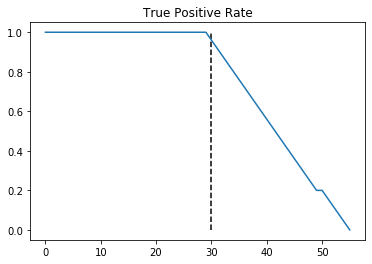

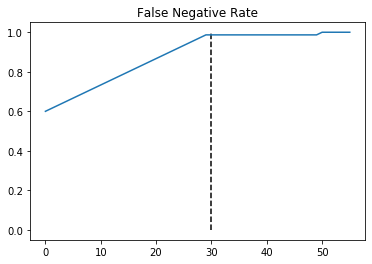

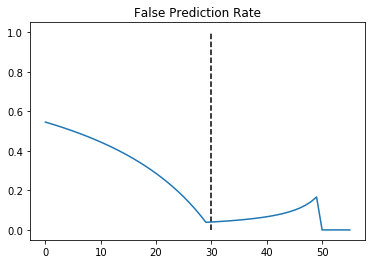

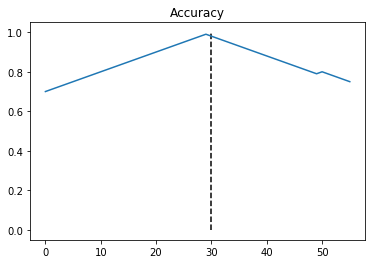

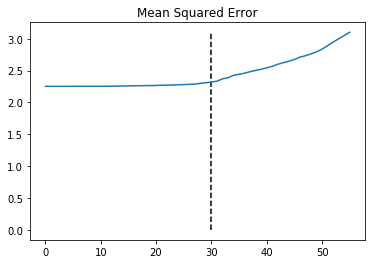

In [63]:
def order_edges(W, edges):
    
    results = []
    
    # copy edges in a matrix that we iteratively shrink
    W_remove = W.copy()
    
    # print W
    print(np.round(W_remove, 2), "\n")
    
    # check scores
    result = h.score(X, W_remove, W_true)
    results.append(result)
    print()
    
    for i in range(len(edges)):
        # remove this edge from W
        W_remove[edges[-(i + 1)][0] - 1][edges[-(i + 1)][1] - 1] = 0
        
        # print W
        print(np.round(W_remove, 2), "\n")
    
        ## check scores
        # tpr: True Positive Rate; Rate of correctly predicted edges.
        # fnr: True Negative Rate; Rate of corretly predicted non-edges.
        # fpr: False Prediction Rate; Rate of predicted edges that are not edges.
        # acc: Accuracy; Rater of correctly predicted edges and non-edges.
        # mse: Mean Squared Error: Average squared L2 loss per timestep
        result = h.score(X, W_remove, W_true)
        
        results.append(result)
        
        print()
    
    results = np.array(results)
    
    titles = ['True Positive Rate', 'False Negative Rate', 'False Prediction Rate', 'Accuracy', 'Mean Squared Error']
    
    for i in range(4):
        plt.title(titles[i])
        plt.plot(range(0, len(edges) + 1), results[:, i])
        plt.vlines(n * (n + 1) / 2 - s, 0, 1, linestyle = '--')
        plt.show()
    
    plt.title(titles[-1])
    plt.plot(range(0, len(edges) + 1), np.log(results[:, 4]))
    plt.vlines(n * (n + 1) / 2 - s, 0, max(np.log(results[:, 4])), linestyle = '--')
    plt.show()

order_edges(W, edges)

### When to stop
However, when do we stop pruning? This is a difficult choice. We can e.g. prune all edges who do not significantly improve the model fit (e.g. BIC / AIC). We can e.g. prune all edges that do not contribute enough to the loss value (e.g. by “curvature” in the loss function). The less you prune, the more predictive your model is. 

### Interesting finds
You might expect that when you greedily select the edge that improves the most, that the score will also increase the most. However, this seems not to be the case, as the score-differential is not strictly decreasing.

However, we see that the score itself is strictly increasing, which makes sense.

In [ ]:
import scipy.stats as scistat
print(np.shape(X_large))
print(np.shape(y_large[:,0]))

print(scores[-1])
X_regress = X_large @ omp_fit.coef_

slope, intercept, r_value, p_value, std_err = scistat.linregress(X_regress, y_large[:, 0])
print(r_value ** 2)